# Imports:

# Animation stuff

In [56]:
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [57]:
#TODO:
# Add Useful Player Labels
# Add ability to keep or remove the extra stuff (line markers etc)
# Add Team Colors to dict
# Turn into Function 

def animate_play(tracking_df, play_df,players,pffScoutingData, gameId,playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    # selected_play_df = tracking_df
    
    # tracking_players_df = tracking_df
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    # selected_tracking_df = tracking_df
    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0],
                                                                                      selected_player_df["pff_blockType"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

# All data

### Imports

In [58]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime
import missingno as msno
import seaborn as sns
import plotly.graph_objects as go

In [59]:
os.getcwd()

'c:\\Users\\OaklandHillsMansion\\Desktop\\codeCAMP\\kaggle\\nfl_big_data_2023'

### Read In csv's

In [60]:
# Read In csvs
games = pd.read_csv("./data/games.csv")
plays = pd.read_csv("./data/plays.csv")
players = pd.read_csv("./data/players.csv")
week1 = pd.read_csv("./data/week1.csv")
# week1_copy = pd.read_csv("./data/week1 copy.csv")
pffScoutingData = pd.read_csv("./data/pffScoutingData.csv")
# pffScoutingData = pd.read_csv("./data/pffScoutingData copy.csv")

In [61]:
# pffScoutingData['unit'] = np.where(pffScoutingData.pff_role.isin(['Coverage', 'Pass Rush']), "def", np.where(pffScoutingData.pff_role.isin(['Pass']), "qb", "off"))
# pffScoutingData.to_csv('./data/pffScoutingData.csv', index=False)
# pffScoutingData.head(9)

In [62]:
# def create_adj_fac(week_df):
#     test_df = week_df.copy()

#     test_df = test_df[(test_df.team == 'football') & (test_df.frameId == 1)]

#     test_df['x_fac'] = 100 - test_df.x 
#     test_df['y_fac'] = 25 - test_df.y

#     # test_df = test_df[['gameId', 'playId','x_fac', 'y_fac', 'x_adj', 'y_adj']]
#     test_df = test_df[['gameId', 'playId','x_fac', 'y_fac']]

#     return test_df


# def modify_week_file(week_df):

#     test_df = create_adj_fac(week_df)
#     test_out_df = week_df.copy()

#     test_out_df = test_out_df.merge(test_df, how='inner', on=['gameId', 'playId'])

#     test_out_df['x_adj'] = test_out_df.x + test_out_df['x_fac']
#     test_out_df['y_adj'] = test_out_df.y + test_out_df['y_fac']

#     test_out_df['nflId'] = test_out_df.nflId.astype('Int64')
#     return test_out_df

In [63]:
# print(week1_copy.shape)
# week1 = modify_week_file(week1_copy)
# week1.to_csv('./data/week1.csv', index=False)

# print(week1.shape)
# print(week1.nflId.unique())
# len(week1.nflId.unique())
# print(week1.gameId.unique())

### Join all data

In [64]:
joined_all = pd.merge(games,plays,how="inner",on = "gameId")
joined_all = pd.merge(joined_all,week1,how="inner",on=["gameId","playId"])
# left join on players to keep football records
joined_all = pd.merge(joined_all,players,how="left",on = "nflId")
joined_all = pd.merge(joined_all, pffScoutingData, how="left",on = ["nflId","playId","gameId"])

### Focused df

In [65]:
id = 2021090900
eda_df = joined_all[(joined_all.gameId==id)]

eda_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,playId,playDescription,quarter,...,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,unit
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qb
1,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qb
2,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qb
3,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qb
4,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qb


In [66]:
eda_df.pff_blockType.value_counts()/eda_df.pff_blockType.value_counts().sum()

PP    0.542224
SW    0.110139
PA    0.102903
CL    0.077258
PT    0.073182
PU    0.025005
NB    0.022806
CH    0.016853
SR    0.013464
BH    0.008884
UP    0.007282
Name: pff_blockType, dtype: float64

c:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:ylabel='pff_blockType'>

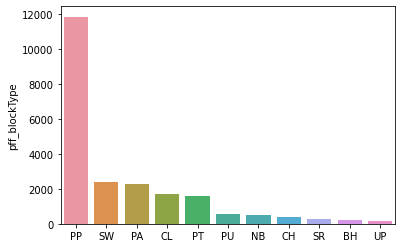

In [67]:
sns.barplot(eda_df.pff_blockType.value_counts().index, eda_df.pff_blockType.value_counts())

## Beginning

### Configs

In [68]:
gameId_num = 2021090900
playId_num = 187
matchup_framId_num = 20
indc_framId_num = 30

### Focused df

In [69]:
def get_focused_df(joined_all, gameId_num):
    focused_df = joined_all[(joined_all.gameId==gameId_num)].copy()
    # focused_df = joined_all.copy()
    # focused_df.head()
    return focused_df

### Get o & d line frames

In [98]:
def get_od_line_df(focused_df):
    o_line_df = focused_df[~(focused_df.pff_blockType.isna())][['nflId', 'playId', 'pff_blockType', 'pff_nflIdBlockedPlayer', 'x', 'y', 'frameId', 'displayName']]
    o_line_df = o_line_df[o_line_df.pff_blockType != 'CH'][['nflId', 'playId', 'pff_blockType', 'pff_nflIdBlockedPlayer', 'x', 'y', 'frameId', 'displayName']]
    # o_line_df = focused_df[~(focused_df.pff_blockType.isna())][['nflId', 'playId', 'pff_blockType', 'pff_nflIdBlockedPlayer', 'x', 'y', 'frameId', 'displayName']]
    d_line_df = focused_df[focused_df.pff_role == 'Pass Rush'][['nflId', 'playId', 'x', 'y', 'frameId', 'displayName']]
    return o_line_df, d_line_df

### Delta % - Blockers vs Rushers

In [71]:
# o_num_blockers =  o_line_df.groupby(['playId'])['nflId'].nunique()
# d_num_rushers = d_line_df.groupby(['playId'])['nflId'].nunique()

# blockers_vs_rushers = pd.concat([o_num_blockers, d_num_rushers], axis=1)

# blockers_vs_rushers.columns = ['nflId_off', 'nflId_def']
# blockers_vs_rushers['delta_off_def'] = blockers_vs_rushers['nflId_off'] - blockers_vs_rushers['nflId_def']

# blockers_vs_rushers.sort_values(by='delta_off_def',inplace=True)
# blockers_vs_rushers.reset_index(inplace=True)
# blockers_vs_rushers

# bvr_stats = blockers_vs_rushers.delta_off_def.value_counts()
# bvr_stats['delta%'] = blockers_vs_rushers.delta_off_def.value_counts()/blockers_vs_rushers.delta_off_def.sum()

# blockers_vs_rushers.delta_off_def.value_counts()/blockers_vs_rushers.delta_off_def.sum()

### Blockers vs Rushers

In [72]:
def get_blockers_vs_rushers(o_line_df, d_line_df):
    
    o_num_blockers =  o_line_df.groupby(['playId'])['nflId'].nunique()
    d_num_rushers = d_line_df.groupby(['playId'])['nflId'].nunique()

    blockers_vs_rushers = pd.concat([o_num_blockers, d_num_rushers], axis=1)

    blockers_vs_rushers.columns = ['nflId_off', 'nflId_def']
    blockers_vs_rushers['delta_off_def'] = blockers_vs_rushers['nflId_off'] - blockers_vs_rushers['nflId_def']

    blockers_vs_rushers.sort_values(by='delta_off_def',inplace=True)
    blockers_vs_rushers.reset_index(inplace=True)

    # print('\nblockers_vs_rushers: \n',blockers_vs_rushers.head())

    return blockers_vs_rushers

### Num blockers and rushers

In [73]:
def get_num_blockers_rushers(o_line_df, d_line_df, playId_num):

    blockers_vs_rushers = get_blockers_vs_rushers(o_line_df, d_line_df)
    num_blockers = blockers_vs_rushers[blockers_vs_rushers.playId == playId_num].nflId_off.values[0]
    num_rushers = blockers_vs_rushers[blockers_vs_rushers.playId == playId_num].nflId_def.values[0]

    return (num_blockers, num_rushers)

### Animation

In [74]:
animate_play(week1, plays, players, pffScoutingData, 2021090900,playId_num).show()

### Matchup Adjustments

#### Function - when blockers and passers are equal

In [75]:
def equal_blockers_passers(o_line_df, d_line_df, matchup_framId_num, playId_num):
    
    o_line_frame_20_df = o_line_df[(o_line_df['frameId'] == matchup_framId_num)&(o_line_df['playId'] == playId_num)]
    d_line_frame_20_df = d_line_df[(d_line_df['frameId'] == matchup_framId_num)&(d_line_df['playId'] == playId_num)]

    o_line_frame_20_df = o_line_frame_20_df.sort_values(by=['playId', 'y']).reset_index(drop=True)
    d_line_frame_20_df = d_line_frame_20_df.sort_values(by=['playId', 'y']).reset_index(drop=True)

    matchup_adj = pd.concat([o_line_frame_20_df, d_line_frame_20_df], axis=1)
    matchup_adj['adj_BlockedPlayer'] = matchup_adj.iloc[:,8]

    return matchup_adj

#### Function - when more blockers than rushers are equal

In [76]:
def more_blockers_passers(o_line_df, d_line_df, matchup_framId_num, playId_num):
    
    o_line_frame_20_df = o_line_df[(o_line_df['frameId'] == matchup_framId_num)&(o_line_df['playId'] == playId_num)]
    d_line_frame_20_df = d_line_df[(d_line_df['frameId'] == matchup_framId_num)&(d_line_df['playId'] == playId_num)]

    o_line_frame_20_df = o_line_frame_20_df.sort_values(by=['playId', 'y']).reset_index(drop=True)
    d_line_frame_20_df = d_line_frame_20_df.sort_values(by=['playId', 'y']).reset_index(drop=True)

    matchup_adj = pd.concat([o_line_frame_20_df, d_line_frame_20_df], axis=1)
    matchup_adj = o_line_frame_20_df.merge(d_line_frame_20_df, how='cross', suffixes=['_off', '_def'])
    matchup_adj['delta'] = abs(matchup_adj['y_off'] - matchup_adj['y_def'])

    matchup_adj = matchup_adj.sort_values(by=['displayName_off', 'delta'], inplace=False)
    matchup_adj.sort_values(by=['delta'], inplace=True)
    matchup_adj['adj_BlockedPlayer'] = matchup_adj.iloc[:,8]

    matchup_adj.reset_index(drop=True, inplace=True)
    matchup_adj = match_rushers_blockers(matchup_adj, num_blockers, num_rushers)
    
    return matchup_adj

##### Function - uses df returned from the function above to match rushers to blockers

In [77]:
def match_rushers_blockers(matchup_adj, num_blockers, num_rushers):

    idx_list = []
    o_list = []
    d_list = []

    if num_blockers > num_rushers:
        num = num_rushers
    else:
        num = num_blockers

    for i, row in matchup_adj.iterrows():

        if i == 0:
            idx_list.append(i)
            o_list.append(row.displayName_off)
            d_list.append(row.displayName_def)

        elif not (row.displayName_off in (o_list) or row.displayName_def in (d_list)):
            idx_list.append(i)
            o_list.append(row.displayName_off)
            d_list.append(row.displayName_def)

        if len(o_list) == num:
            # print(o_list)
            # print(d_list)
            # print(idx_list)
            break
    
    # Use idx_list from above to select appropraite match up rows
    matchup_adj = matchup_adj.iloc[idx_list]

    # Map blockers to rushers
    matchup_adj = matchup_adj.iloc[:,[0,-1]]


    return matchup_adj

### Merge matchup_adj with o-line, d-line & qb data

#### Get o_frame_indc

##### Function - when blockers equal rushers

In [78]:
def check_frameId_max(o_line_df, playId_num, indc_framId_num):
    frameId_max = o_line_df[o_line_df['playId'] == playId_num]['frameId'].max()

    if frameId_max < indc_framId_num:
        indc_framId_num = frameId_max
        
    return indc_framId_num

In [79]:
def o_frame_30_equal(o_line_df, indc_framId_num, playId_num, matchup_adj):

    o_frame_30_df = o_line_df[(o_line_df['frameId'] == indc_framId_num)&(o_line_df['playId'] == playId_num)]
    # print(o_frame_30_df.columns)
    # print('\n\n\n')
    
    matchup_adj = matchup_adj.iloc[:,[0,-1]]
    # print(matchup_adj.head)
    o_frame_30_df = o_frame_30_df.merge(matchup_adj, on='nflId', how='left')
    return o_frame_30_df

##### Function - when blockers > rushers

In [80]:
def o_frame_30_more(o_line_df, indc_framId_num, playId_num, matchup_adj):
    o_frame_30_df = o_line_df[(o_line_df['frameId'] == indc_framId_num)&(o_line_df['playId'] == playId_num)]
    o_frame_30_df = o_frame_30_df.merge(matchup_adj, left_on='nflId', right_on='nflId_off', how='left')
    # print(matchup_adj.head)
    return o_frame_30_df

### Check num blockers vs num rushers

In [81]:
def get_o_frame_30(num_blockers, num_rushers, o_line_df, d_line_df, playId_num, matchup_framId_num, indc_framId_num):

    if num_blockers == num_rushers:
        matchup_adj = equal_blockers_passers(o_line_df, d_line_df, matchup_framId_num, playId_num)
        o_frame_30_df = o_frame_30_equal(o_line_df, indc_framId_num, playId_num, matchup_adj)

    else:
        matchup_adj = more_blockers_passers(o_line_df, d_line_df, matchup_framId_num, playId_num)
        o_frame_30_df = o_frame_30_more(o_line_df, indc_framId_num, playId_num, matchup_adj)

    return o_frame_30_df

#### Get d_frame_indc

In [82]:
def get_d_frame_30(d_line_df, playId_num, indc_framId_num):
    d_frame_30_df = d_line_df[(d_line_df['frameId'] == indc_framId_num)&(d_line_df['playId'] == playId_num)]
    return d_frame_30_df

#### Merge o & d line

In [83]:
def get_o_d_line_df(o_frame_30_df, d_frame_30_df):
    o_d_line_df = o_frame_30_df.merge(d_frame_30_df, how='outer', left_on=['adj_BlockedPlayer', 'playId', 'frameId'], right_on=['nflId', 'playId', 'frameId'], suffixes=['_off', '_def'])
    return o_d_line_df

#### Get QB data

In [84]:
def get_qb_coords(focused_df):
    qb_coords = focused_df[focused_df.officialPosition == "QB"][['nflId', 'playId', 'x', 'y', 'frameId', 'displayName']]
    return qb_coords

#### Merge qb data with o & d line

In [85]:
def merge_qb_od_data(qb_coords, o_d_line_df):
    all_df = qb_coords.merge(o_d_line_df, on=['playId', 'frameId'], how='inner', suffixes=['_qb',''])
    return all_df

### Get Euclidean Dist.

In [86]:
def Euclidean_Dist(df, cols=['x', 'y']):

    off_array = np.linalg.norm(df[['x', 'y']].values - df[['x_off', 'y_off']].values, axis=1)
    def_array = np.linalg.norm(df[['x', 'y']].values - df[['x_def', 'y_def']].values, axis=1)
    df["off_qb_dist"] = off_array
    df["def_qb_dist"] = def_array

    return df

### Get blocker - rusher deltas

In [87]:
def get_blocker_rusher_deltas(all_df):
    all_df['line_diff'] = all_df.off_qb_dist - all_df.def_qb_dist
    return all_df

### Beat %

In [88]:
def get_beat_perc(full_df, full_beat_df):
    full_df_gb = full_df.groupby(['gameId', 'displayName_off', 'nflId_off']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    full_df_beat_gb = full_beat_df.groupby(['displayName_off', 'nflId_off']).size().reset_index(name='counts')

    beat_perc_df = full_df_beat_gb.merge(full_df_gb, how='inner', on=['displayName_off', 'nflId_off'])
    beat_perc_df['%'] = beat_perc_df.counts_x / beat_perc_df.counts_y *100

    return beat_perc_df

# print(beat_perc_df)

### Score O players

In [111]:
def score_o_player(full_df_merge, full_df_beat):    
    score_df_list = []
    player_df_list = []
    o_player_list = list(full_df_merge.displayName_off.values)

    for player in o_player_list:
        player_df = full_df_beat[full_df_beat.displayName_off == player].copy()
        player_df['x_delta'] = abs(player_df.x - player_df.x_off) - abs(player_df.x - player_df.x_def)
        player_df['y_delta'] = abs(player_df.y - player_df.y_off) - abs(player_df.y - player_df.y_def)

        player_df['dir'] = "outside"
        player_df['dir'] = np.where(player_df['x_delta'] < 0, "inside", player_df['dir'])

        player_df['blockers_delta'] = player_df['num_blockers'] - player_df['num_rushers']
        player_df['score'] = player_df['blockers_delta']
        player_df['score'] = np.where(player_df['dir'] == 'inside', player_df['score'] + 1, player_df['score'])

        player_grade_df = player_df.groupby(['displayName_off'])['score'].sum().reset_index()

        # player_df
        score_df_list.append(player_grade_df)
        player_df_list.append(player_df)

        score_df = pd.concat(score_df_list, axis=0, ignore_index=True)
        all_player_df = pd.concat(player_df_list, axis=0, ignore_index=True)

    return score_df, all_player_df

# player_df.head()

### Grade O players for the game

In [90]:
def grade_o_game(full_df_merge, score_df):
    o_grade_book = full_df_merge.merge(score_df, how='inner', on='displayName_off')
    o_grade_book["grade"] = 100 - o_grade_book["%"] - (o_grade_book["%"] * (o_grade_book["score"] * 2 / 100))
    return o_grade_book

### Concat all_df's

In [108]:
# gameId_num = 2021090900
# playId_num = 187

matchup_framId_num = 20
indc_framId_num = 30

game_df_list = []
game_df_beat_list = []
o_grade_book_list = []
full_all_player_df_list = []

# List of gameIds
gameId_list = list(joined_all.gameId.unique())

# Iterate through each game, then each play
for gameId_num in gameId_list:
    print(gameId_num)
    
    # Filters the joined_all df by the gameId_num
    focused_df = get_focused_df(joined_all, gameId_num)
    # print(focused_df.head())

    o_line_df, d_line_df = get_od_line_df(focused_df)
    # print(d_line_df)

    # List of playId
    palyId_list = list(o_line_df.playId.unique())

    all_df_list = []
    for playId_num in palyId_list:
        num_blockers, num_rushers = get_num_blockers_rushers(o_line_df, d_line_df, playId_num)

        indc_framId_num = check_frameId_max(o_line_df, playId_num, indc_framId_num)

        o_frame_30_df = get_o_frame_30(num_blockers, num_rushers, o_line_df, d_line_df, playId_num, matchup_framId_num, indc_framId_num)      
        #remove nflId_off
        o_frame_30_df.drop(['nflId_off'], axis=1, errors='ignore', inplace=True)

        d_frame_30_df = get_d_frame_30(d_line_df, playId_num, indc_framId_num)
        o_d_line_df = get_o_d_line_df(o_frame_30_df, d_frame_30_df)

        qb_coords = get_qb_coords(focused_df)
        all_df = merge_qb_od_data(qb_coords, o_d_line_df)

        all_df = Euclidean_Dist(all_df)
        all_df = get_blocker_rusher_deltas(all_df)

        # add num blockers and rushers
        all_df['num_blockers'] = num_blockers
        all_df['num_rushers'] = num_rushers

        all_df.reset_index(drop=True, inplace=True)
        all_df_list.append(all_df)
    
    game_df = pd.concat(all_df_list, axis=0, ignore_index=True)
    game_df["gameId"] = gameId_num
    # print(game_df.head())


    game_df_beat = game_df[game_df.line_diff > .1].reset_index(drop=True)

    beat_perc_df = get_beat_perc(game_df, game_df_beat)
    # print(beat_perc_df.head(10))

    score_df, all_player_df = score_o_player(beat_perc_df, game_df_beat)
    # print(score_df.head(10))

    o_grade_book = grade_o_game(beat_perc_df, score_df)

    # game_df_list.append(game_df)
    # game_df_beat_list.append(game_df_beat)
    
    o_grade_book_list.append(o_grade_book)
    full_all_player_df_list.append(all_player_df)

    

2021090900
full_df_merge     displayName_off  nflId_off  counts_x      gameId  counts_y          %
0        Alex Cappa    46163.0         4  2021090900        44   9.090909
1        Ali Marpet    42404.0         3  2021090900        44   6.818182
2      Blake Jarwin    45532.0         1  2021090900         4  25.000000
3   Connor McGovern    47873.0         3  2021090900        53   5.660377
4    Dalton Schultz    46206.0         1  2021090900         4  25.000000
5     Donovan Smith    42377.0         1  2021090900        44   2.272727
6   Ezekiel Elliott    43293.0         2  2021090900         8  25.000000
7     La'el Collins    42654.0         7  2021090900        53  13.207547
8    Rob Gronkowski    35481.0         2  2021090900         6  33.333333
9       Ryan Jensen    40151.0         1  2021090900        44   2.272727
10    Tristan Wirfs    52421.0         3  2021090900        44   6.818182
11    Tyler Biadasz    52554.0         2  2021090900        53   3.773585
12      Tyron

In [109]:
full_all_player_df = pd.concat(full_all_player_df_list, axis=0, ignore_index=True)

# Adding team and week column to the df
full_all_player_df['team'] = full_all_player_df['nflId_off'].map(week1.drop_duplicates('nflId').set_index('nflId')['team'])
full_all_player_df['week'] = 'week1'
# full_all_player_df.sort_values(by='grade', inplace=True)

# Removing PA playIds
pa_palyId_list = list(full_all_player_df[full_all_player_df.pff_blockType == "PA"].playId.unique())
full_all_player_df = full_all_player_df[~(full_all_player_df.playId.isin(pa_palyId_list))]

full_all_player_df.head()

,nflId,playId,x,y,frameId,displayName,nflId_off,pff_blockType,pff_nflIdBlockedPlayer,x_off,...,num_blockers,num_rushers,gameId,x_delta,y_delta,dir,blockers_delta,score,team,week
0,25511.0,97,33.77,23.43,30,Tom Brady,46163.0,SW,53441.0,37.38,...,5,5,2021090900,0.29,-0.18,outside,0,0,TB,week1
1,25511.0,434,23.62,27.81,27,Tom Brady,46163.0,PP,44955.0,26.27,...,6,5,2021090900,2.40,-0.29,outside,1,1,TB,week1
2,25511.0,2032,64.53,24.06,24,Tom Brady,46163.0,PP,41363.0,61.70,...,5,4,2021090900,2.15,-0.68,outside,1,1,TB,week1
3,25511.0,3062,53.45,30.00,24,Tom Brady,46163.0,PP,44955.0,49.45,...,5,4,2021090900,1.85,-0.93,outside,1,1,TB,week1
4,25511.0,559,88.94,28.88,27,Tom Brady,42404.0,PP,53504.0,94.14,...,5,4,2021090900,0.61,-0.39,outside,1,1,TB,week1


In [110]:
full_df = pd.concat(o_grade_book_list, axis=0, ignore_index=True)

# Adding team and week column to the df
full_df['team'] = full_df['nflId_off'].map(week1.drop_duplicates('nflId').set_index('nflId')['team'])
full_df['week'] = 'week1'
full_df.sort_values(by='grade', inplace=True)
full_df.reset_index(drop=True, inplace=True)

full_df.head()

,displayName_off,nflId_off,counts_x,gameId,counts_y,%,score,grade,team,week
0,Tyler Higbee,43399.0,1,2021091213,1,100.0,5,-10.0,LA,week1
1,Amon-Ra St. Brown,53541.0,1,2021091204,1,100.0,3,-6.0,DET,week1
2,Nick Westbrook-Ikhine,53074.0,1,2021091207,1,100.0,3,-6.0,TEN,week1
3,Robert Tonyan,45635.0,1,2021091211,1,100.0,3,-6.0,GB,week1
4,Sterling Shepard,43329.0,1,2021091212,1,100.0,2,-4.0,NYG,week1


In [114]:
playId_num = 3306
gameId = 2021090900
animate_play(week1, plays, players, pffScoutingData, gameId, playId_num).show()

 ### Write to Excel

In [112]:
full_df.to_excel(r".\output\full_df.xlsx", sheet_name='grades')
full_all_player_df.to_excel(r".\output\full_all_player_df.xlsx", sheet_name='indy_scores')

In [76]:
pffScoutingData.columns

Index(['gameId', 'playId', 'nflId', 'pff_role', 'pff_positionLinedUp',
       'pff_hit', 'pff_hurry', 'pff_sack', 'pff_beatenByDefender',
       'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed',
       'pff_nflIdBlockedPlayer', 'pff_blockType', 'pff_backFieldBlock'],
      dtype='object')

In [77]:
# pffScoutingData.columns
pffScoutingData_vip_cols = ['pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']
pffScoutingData_vip_cols = ['pff_hit', 'pff_hurry', 'pff_sack']

pff_sub = pffScoutingData.loc[pffScoutingData[pffScoutingData_vip_cols].gt(0).any(1)]
print(pffScoutingData.shape)

pff_needed_cols = ["gameId", "playId", "nflId"] + pffScoutingData_vip_cols
pff_sub = pff_sub[pff_needed_cols]
pff_sub = pff_sub[pff_sub.gameId == 2021090900].reset_index(drop=True)

# pff_sub.rename(columns={"nflId": "nflId_off"}, inplace = True)
pff_sub.rename(columns={"nflId": "nflId_def"}, inplace = True)

pff_sub.head()

(188254, 15)


,gameId,playId,nflId_def,pff_hit,pff_hurry,pff_sack
0,2021090900,97,41263,0.0,1.0,0.0
1,2021090900,97,42403,0.0,1.0,0.0
2,2021090900,97,53441,0.0,1.0,0.0
3,2021090900,97,53504,0.0,1.0,0.0
4,2021090900,349,38588,1.0,0.0,0.0


In [78]:
# joined_all = pd.merge(full_df, pff_sub, how="left", on = ["nflId_off","playId"])
joined_all = pd.merge(full_df, pff_sub, how="left", on = ["nflId_def","playId"])
joined_all.head(10)

,nflId,playId,x,y,frameId,displayName,nflId_off,pff_blockType,pff_nflIdBlockedPlayer,x_off,...,x_def,y_def,displayName_def,off_qb_dist,def_qb_dist,line_diff,gameId,pff_hit,pff_hurry,pff_sack
0,25511.0,97,33.77,23.43,30,Tom Brady,46163.0,SW,53441.0,37.38,...,37.09,22.84,Micah Parsons,3.633208,3.372017,0.261191,2.021091e+09,0.0,1.0,0.0
1,25511.0,97,33.77,23.43,30,Tom Brady,52421.0,PP,53441.0,37.20,...,36.98,24.29,Demarcus Lawrence,3.650671,3.323206,0.327465,2.021091e+09,0.0,1.0,0.0
2,43424.0,349,63.49,28.76,30,Dak Prescott,43293.0,PU,38588.0,61.39,...,62.57,30.13,Lavonte David,3.034156,1.650242,1.383913,2.021091e+09,1.0,0.0,0.0
3,43424.0,349,63.49,28.76,30,Dak Prescott,46206.0,CH,41915.0,52.19,...,62.00,33.59,Ndamukong Suh,13.436625,5.054602,8.382023,NaN,NaN,NaN,NaN
4,25511.0,434,23.62,27.81,27,Tom Brady,46163.0,PP,44955.0,26.27,...,23.37,23.24,Demarcus Lawrence,5.033975,4.576833,0.457142,NaN,NaN,NaN,NaN
5,25511.0,559,88.94,28.88,27,Tom Brady,42404.0,PP,53504.0,94.14,...,93.53,28.02,Osa Odighizuwa,5.221197,4.669872,0.551326,NaN,NaN,NaN,NaN
6,25511.0,583,99.97,23.80,27,Tom Brady,35481.0,PA,41263.0,101.97,...,100.00,19.90,Demarcus Lawrence,4.232363,3.900115,0.332248,NaN,NaN,NaN,NaN
7,43424.0,764,46.35,28.71,27,Dak Prescott,37082.0,PA,35454.0,42.86,...,43.78,22.38,Jason Pierre-Paul,7.272173,6.831823,0.440350,NaN,NaN,NaN,NaN
8,43424.0,764,46.35,28.71,27,Dak Prescott,45532.0,SR,53461.0,39.27,...,40.63,31.15,Joe Tryon,9.083089,6.218682,2.864407,NaN,NaN,NaN,NaN
9,25511.0,1312,19.66,31.15,24,Tom Brady,52421.0,PA,41363.0,14.76,...,14.91,30.68,Brent Urban,5.026370,4.773196,0.253174,NaN,NaN,NaN,NaN


In [79]:
list_num = 41
all_df_list[list_num][all_df_list[list_num].line_diff > -.05]

,nflId,playId,x,y,frameId,displayName,nflId_off,pff_blockType,pff_nflIdBlockedPlayer,x_off,y_off,displayName_off,adj_BlockedPlayer,nflId_def,x_def,y_def,displayName_def,off_qb_dist,def_qb_dist,line_diff
1,43424.0,2233,70.49,29.84,24,Dak Prescott,42654.0,PP,41915.0,74.73,25.02,La'el Collins,41915.0,41915.0,73.6,24.46,Shaquil Barrett,6.419502,6.214218,0.205284


In [80]:
week1.event.value_counts()

None                         1028537
ball_snap                      26956
pass_forward                   24127
autoevent_ballsnap             13455
autoevent_passforward          12627
play_action                     5382
qb_sack                         1334
run                             1219
pass_arrived                    1150
autoevent_passinterrupted        690
man_in_motion                    598
line_set                         552
shift                            437
pass_tipped                      299
first_contact                    230
qb_strip_sack                    184
pass_outcome_incomplete          138
pass_outcome_caught               69
fumble                            46
fumble_offense_recovered          23
huddle_break_offense              23
lateral                           23
handoff                           23
Name: event, dtype: int64

In [81]:
# week1[week1.event == 'first_contact'].iloc[:, :4].drop_duplicates(subset=['playId'])

In [83]:
playId_num = 2419
gameId = 2021090900
animate_play(week1, plays, players, pffScoutingData, gameId, playId_num).show()